In [1]:
def windows(sample_data, window_size):
    start = 0
    while start < sample_data.shape[1]:
        yield start, start + window_size
        start += (window_size)
        
def ts_to_supervise(data,window_size,n_var):
    """
        Convert input data into LSTMs data
        
        args:
        window_size : the length of time-series. All input columns must have identical length
        n_var : number of features regardless the time-series period
        
        returns:
        result_array : A 3-D LSTMs array 
        
    """
    import numpy as np

    result_array = np.asarray(np.zeros((data.shape[0],window_size,n_var)))
    for i in range(0,data.shape[0]):
    
        segments = None
        
        for (start, end) in windows(data, window_size):
            if (data[:,start:end].shape[1]== (window_size)):
                signal = np.asarray(data[i,start:end])
                if segments is None:
                    segments = signal
                else:
                    segments = np.vstack([segments, signal])
        segments = segments.transpose()

        result_array[i,:,:] = segments
    return(result_array)

def drop_col(columns, col_thresh, sample_x):
    """
        Drop zero-inflation columns
    """
    col_to_drop = []
    zero_probs = []
    
    for col in columns:
        
        zero_prob = sum((sample_x[col] == 0).astype(int))/len(sample_x[col])
        
        zero_probs.append(zero_prob)
        
        if sample_x[col].dtype != 'int64':
            sample_x[col].astype('int64')
            print("[features]: numerize colname names:" ,col)  
        
        if zero_prob > col_thresh:
            col_to_drop.append(col)
            print('[features]:',col, "has been dropped with zeros more than", zero_prob)
    return col_to_drop, zero_probs

def get_feature_name(col_list):
    """
        Get the time-series features' names regardless of the time period
    """
    feature_names =[]
    for col in col_list:
        feature_name = col.split('_')[0]
        feature_names.append(feature_name)
    return(feature_names)

def features_extract (sample_df, ts_len):
    """
        Filter time-series features from the input data and return a list of those features' names
    """
    raw_features = sample_df.columns
    fea_list = get_feature_name(raw_features)

    ts_features = []
    for col in set(fea_list):
        if fea_list.count(col) == ts_len:
            ts_features.append(col)
    print('[features]: ',len(ts_features),"time series features founded from data...")

    output_features = []
    for feature_name in ts_features:
        try:
            print('[features]: generating windowed average deltas...',feature_name)
            # get the column names
            feats = list(sample_df.filter(regex=(feature_name+'*_[0-59]')).columns)
            print(len(feats),"founded")
        except:
             print('[features]: Oops! features name not found...')
        output_features.append(feats)
    output_features = [item for sublist in output_features for item in sublist]
    output_features = list(set(output_features))
    return(output_features)


def train_test_split(sample_data, valsize = 0.05, random_state = 42):
    
    import pandas as pd
    from sklearn.model_selection import train_test_split

    _, _, train_idx, val_idx = train_test_split(sample_data, sample_data.index, test_size=valsize, random_state=random_state)
    
    sample_data.ix[train_idx,'split'] = 'Train'
    sample_data.ix[val_idx,'split'] = 'Validation'
    
    print(sample_data['split'].value_counts())
    
    return(sample_data)

def plot_confusion_matrix(truth, predicted, labels={}, save_name='',
                          title='Confusion Matrix', norm=1, suppress_values=False,
                          diagonal_values=False,
                          font_size=10,
                          cmin=0,cmax=1,
                          cut_off = 1
                          ):
    # make confusion matrix from truth and predicted for classes
    # define the confusion matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import numpy as np
    
    conf_mat = confusion_matrix(truth,predicted,labels = labels)
    
    #normalise
    if norm:
        conf_mat =  conf_mat.astype('float')/conf_mat.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(9,9))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    cb = fig.colorbar(res)
    
    res.set_clim(cmin, cmax)
    
    # add number overlay
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if (not suppress_values or (diagonal_values and i==j)) and c>0 :
                cent = .1
                if diagonal_values:
                    cent = .3
                
                if norm:
                    d = round(c,2)
                    plt.text(j-cent, i+.0, d, fontsize=font_size)
                else:
                    plt.text(j-cent, i+.0, c, fontsize=font_size)
    
            if (i==j) and c > cut_off:
                cent= 0.3
                plt.text(j-cent, i+.0, 'X', fontsize=font_size)

    # set axes
    plt.xticks(range(len(labels)), labels, rotation = 60, fontsize=font_size)
    plt.yticks(range(len(labels)), labels, rotation = 60, fontsize=font_size)
    
    plt.xlabel('Predicted',fontsize=font_size+4)
    plt.ylabel('Truth',fontsize=font_size+4)
    plt.title(title,fontsize=font_size+5)

    if save_name != '':
        plt.savefig(save_name)
    plt.show()

    
def plot_roc(test_y, pred_y, roc_save_name = None):
    
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    import matplotlib.pyplot as plt
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(test_y, pred_y[:,1])
    roc_auc = auc(fpr, tpr)
    
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
    if roc_save_name != '':
        plt.savefig(roc_save_name)
    plt.show()

In [7]:
sample_df

,Unnamed: 0,0_b,0_ca,0_cec,0_cl,0_cu,0_ec,0_ec_ratio,0_fe,0_k,...,sumSolarRadiation_2016-11-01,sumSolarRadiation_2016-12-01,sz_checkArea,sz_fieldArea,sz_k,sz_n,sz_p,sz_s,sz_yieldTargetFinal,vrCostPerBu
0,0,0.285000,3526.910000,22.150000,4.513333,0.765000,0.226667,2.0,35.650000,340.800000,...,138.9708,116.6616,0.000000,11.209251,0.0,92.500000,35.000000,0.0,57.500000,0.834000
1,1,0.503333,3919.760000,24.263333,3.070000,0.636667,0.240000,2.0,56.606667,274.540000,...,138.9708,116.6616,0.637196,30.773239,0.0,92.500000,35.000000,0.0,65.000000,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.0,NaN,NaN
3,3,0.460000,3382.855000,20.875000,2.842500,0.560000,0.200000,2.0,43.715000,284.740000,...,138.9708,116.6616,0.756918,18.274870,0.0,98.333333,35.000000,0.0,63.333333,1.253333
4,4,0.485000,3858.935000,23.535000,3.696667,0.855000,0.203333,2.0,39.375000,236.930000,...,138.9708,116.6616,0.683034,18.770088,0.0,97.000000,35.000000,0.0,66.000000,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.0,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.0,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.0,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.0,NaN,NaN
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,0.0,0.000000,0.000000,0.0,NaN,NaN


In [65]:
def data_processing(data, label, columns, ts_len, col_thresh, random):
    """
        Pre-process the data to LSTMs data
        In this function, we clean the input dataset with selected columns, delete those zero-inflation columns
        and convert the reserved to LSTMs dataset for LSTM model fitting.
        
        args:
            data : directory of input data
            label : name of the column containing respond variable
            columns : names of the column of features (must be time series type)
            col_thresh : a threshhold value between 0 - 1 for dropping zero-inflation columns
            ts_len : length of time series
            test : True/False, testing data
            
        returns:
            feature_names_reserve: Features names reserved
            feature_names_drop: Features names dropped
            train_array: Processed training X
            val_array: Processed validation X
            test_array: Processed testing X
            Y_train: Processed training Y
            Y_val: Processed validation Y
            Y_test: Processed testing Y
            zero_probs: An array of precentage of zeros each columns
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    
    # Read data
    sample_data = data
    
    # Extract outcome label
    sample_y = sample_data[label]

    # Extract data with interested features
    sample_x = sample_data[columns]
    
    # Obtain columns with a lot of zero values, col_thresh is the threshold for zero percentage
    
#     col_to_drop, zero_probs = drop_col(columns, col_thresh, sample_x)
     
#     sample_x = sample_x.drop(col_to_drop,1)
    
#     # Obtain dropped feature names
#     col_list = list(col_to_drop)
#     feature_names_drop = get_feature_name(col_list)     
#     print('[features]:',len(set(feature_names_drop)),"zero-inflation features")

#     # Obtain reserved feature names
#     col_list = list(sample_x.columns)
#     feature_names_reserve = get_feature_name(col_list)
#     print('[features]:',len(set(feature_names_reserve)),"features will be included in LSTMs model")
    
    x_values = sample_x.values
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     values = scaler.fit_transform(x_values)
#     x_values = scaler.transform(values)
    
    # Train/test split
    sample_data = train_test_split(sample_data, valsize = 0.05, random_state = random)

    # Obtain training data  
    X_train = x_values[sample_data.split=='Train']
    Y_train = sample_y[sample_data.split=='Train']
    # convert training data to LSTM data
    train_array = ts_to_supervise(X_train,ts_len,47)
    
    # Obtain validation data    
    X_val = x_values[sample_data.split=='Validation']
    Y_val = sample_y[sample_data.split=='Validation'] 
    val_array = ts_to_supervise(X_val,ts_len,47)
    
    full_x_array = ts_to_supervise(x_values,ts_len,47)
    
    return full_x_array, train_array, val_array, Y_train, Y_val

def fit_lstm(train_x, train_y, val_x, val_y, epochs, batch_size):
    """
        Fit LSTMs model
        In this function, we fit the LSTMs model with customized parameters
        args:
            train_x : training features
            train_y : training y
            val_x : validation features
            val_y : validation y
            epochs : number of epoch
            batch_size : batch size
        returns:
            lstm_model : fitted LSTM model
    """
    from keras.layers import Dense
    from keras.layers import LSTM, Dropout
    from keras import optimizers
    from keras.models import Sequential
    
    # Initialize model    
    model = Sequential()
    model.add(LSTM(4,input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False))
        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')

    model.summary()
    
    # 128 is the number of hidden units sent forward to the next time step, a.k.a, dimensionality of the output space.
    # input_shape is the dimensionality of the input needed to claim in the first layer.
    # return sequences is a boolean indicating whether to return the last output in the output sequence, or the full sequence.
#     model.add(LSTM(20, input_shape=(train_x.shape[1], train_x.shape[2]),return_sequences=True))
#     model.add(LSTM(10, return_sequences=True))
#     model.add(LSTM(5, return_sequences=False))

    # regular densely-connected NN layer with 2 dimensionality of output space.
#     model.add(Dense(2, activation='softmax'))
    
    # configure the model for training
    # loss is a loss function used in model fitting, we use categorical_crossentropy because we are predicting categorical outcome
    # optimizer is determined for compiping a Keras model
    # matrics is for evaluation matrics and here we use 'accuracy'
#     opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    # summarize the model in table
#     model.summary()
    
    # fit model
    lstm_model = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data= (val_x, val_y), verbose=2
                           , shuffle=False)
    
    return(lstm_model)
def val_lstm(sample_df, model, x_values, y_values, batch_size, cutoff = 0.5, roc_save_name='', cm_save_name = '', result_csv_save_name = ''):
    """
        Validate LSTMs model
        In this function, we validate our fitted LSTMs model with some evaluation plots
        args:
            model : fitted LSTMs model
            test_x : testing features
            test_y : testing y
            batch_size : batch size
            cutoff : predicted y = 1, if Predicted probability > 0.5, else, 0 
            roc_save_name : name of saved roc plot
            cm_save_name : name of saved confusion matrix plot
            result_csv_save_name : name of saved result csv file
        returns:
            result_df : result csv with predicted probability, category, etc.
    """
   
    # get fitted y
    pred_y = model.predict(x_values, batch_size=batch_size, verbose=2)
    
    
    # Combine data
    result_df = pd.concat([sample_df['serial'],sample_df['split'],pd.Series(y_values, name = 'true_y'),pd.Series(pred_y[:,1], name = 'pred_y')],axis = 1)
    
    # Write csv
    result_df.to_csv(result_csv_save_name, sep = '\t')
    
    # draw roc
    plot_roc(y_values, pred_y, roc_save_name = roc_save_name)
    
    # draw confusion matrix
    ypred = [[ 1 if x > cutoff else 0 ]for x in pred_y[:,1]]
    plot_confusion_matrix(truth = y_values, predicted = ypred,labels=[0,1],save_name=cm_save_name)
    
    return result_df

# Functions testing

In [4]:
# Noticed that the input features name in data_processing function must be exactly the same as the column name in data.
# i.e. "MaxExternalPressure_00", "MaxExternalPressure_01", ... "MaxExternalPressure_59", etc..
# Here we manually extract the interested features name ('x_name' below) before running the function.
import pandas as pd
sample_df = pd.read_csv("corrected_yields.csv")
features_list = features_extract(sample_df, 24)

[features]:  47 time series features founded from data...
[features]: generating windowed average deltas... sumNormalIrradiance
24 founded
[features]: generating windowed average deltas... maxDewpoint
24 founded
[features]: generating windowed average deltas... sumDiffuseHorizontalRadiation
24 founded
[features]: generating windowed average deltas... minTemp
24 founded
[features]: generating windowed average deltas... avgApparentTemp
24 founded
[features]: generating windowed average deltas... avgDewpoint
24 founded
[features]: generating windowed average deltas... avgTemp
24 founded
[features]: generating windowed average deltas... minRelativeHumidity
24 founded
[features]: generating windowed average deltas... sumPrecipitation
24 founded
[features]: generating windowed average deltas... avgAirPressure
24 founded
[features]: generating windowed average deltas... maxNormalIrradiance
24 founded
[features]: generating windowed average deltas... maxWindSpeed
24 founded
[features]: generat

In [11]:
1128/24

47.0

In [46]:
# Feature processing
full_array_x, X_train, X_val, Y_train, Y_val = data_processing(data = df_sub, label = 'Json Yield', columns = features_list, ts_len = 24, col_thresh = 0.5, random = 5)

C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\harryhan\Anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

Train         237
Validation     13
Name: split, dtype: int64


In [66]:
# Model fitting
model_lstm = fit_lstm(X_train, Y_train, X_val, Y_val, epochs = 500, batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 4)                 832       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 837
Trainable params: 837
Non-trainable params: 0
_________________________________________________________________
Train on 237 samples, validate on 13 samples
Epoch 1/500
 - 4s - loss: 1684501.4921 - val_loss: 1376554.8905
Epoch 2/500
 - 2s - loss: 1154681.5730 - val_loss: 1365076.9314
Epoch 3/500
 - 2s - loss: 1149277.1401 - val_loss: 1354144.7532
Epoch 4/500
 - 2s - loss: 1144122.9382 - val_loss: 1343549.9516
Epoch 5/500
 - 2s - loss: 1139178.0293 - val_loss: 1333280.6840
Epoch 6/500
 - 2s - loss: 1134433.5204 - val_loss: 1323325.9983
Epoch 7/500
 - 2s - loss: 1129881.3476 - val_loss: 1313674.7584
Epoch 8/500
 - 2s - loss: 1125513.2971 - val_lo

Epoch 118/500
 - 2s - loss: 1019239.8380 - val_loss: 991807.8510
Epoch 119/500
 - 2s - loss: 1019165.8458 - val_loss: 991290.0403
Epoch 120/500
 - 2s - loss: 1019094.1623 - val_loss: 990784.1328
Epoch 121/500
 - 2s - loss: 1019024.5472 - val_loss: 990289.7945
Epoch 122/500
 - 2s - loss: 1018957.1309 - val_loss: 989806.7716
Epoch 123/500
 - 2s - loss: 1018891.5877 - val_loss: 989334.8504
Epoch 124/500
 - 2s - loss: 1018828.1507 - val_loss: 988873.4297
Epoch 125/500
 - 2s - loss: 1018766.4835 - val_loss: 988422.6791
Epoch 126/500
 - 2s - loss: 1018706.6741 - val_loss: 987981.9026
Epoch 127/500
 - 2s - loss: 1018648.5324 - val_loss: 987551.3618
Epoch 128/500
 - 2s - loss: 1018592.4012 - val_loss: 987130.6220
Epoch 129/500
 - 2s - loss: 1018537.6814 - val_loss: 986719.4141
Epoch 130/500
 - 2s - loss: 1018484.7493 - val_loss: 986317.4531
Epoch 131/500
 - 2s - loss: 1018433.0032 - val_loss: 985924.6677
Epoch 132/500
 - 2s - loss: 1018382.7878 - val_loss: 985540.8576
Epoch 133/500
 - 2s - los

 - 2s - loss: 1016639.7823 - val_loss: 970005.6752
Epoch 245/500
 - 2s - loss: 1016636.9479 - val_loss: 969974.5739
Epoch 246/500
 - 2s - loss: 1016634.1335 - val_loss: 969944.4531
Epoch 247/500
 - 2s - loss: 1016631.5333 - val_loss: 969915.0048
Epoch 248/500
 - 2s - loss: 1016628.7079 - val_loss: 969885.5856
Epoch 249/500
 - 2s - loss: 1016625.9776 - val_loss: 969857.1352
Epoch 250/500
 - 2s - loss: 1016623.4040 - val_loss: 969829.4282
Epoch 251/500
 - 3s - loss: 1016620.9189 - val_loss: 969802.4050
Epoch 252/500
 - 3s - loss: 1016618.4918 - val_loss: 969775.8053
Epoch 253/500
 - 3s - loss: 1016616.0072 - val_loss: 969749.4477
Epoch 254/500
 - 2s - loss: 1016613.5972 - val_loss: 969723.9408
Epoch 255/500
 - 2s - loss: 1016611.2323 - val_loss: 969698.9102
Epoch 256/500
 - 2s - loss: 1016608.9054 - val_loss: 969674.5288
Epoch 257/500
 - 2s - loss: 1016606.7854 - val_loss: 969650.6001
Epoch 258/500
 - 2s - loss: 1016604.5835 - val_loss: 969627.2188
Epoch 259/500
 - 2s - loss: 1016602.533

Epoch 371/500
 - 2s - loss: 1016516.1781 - val_loss: 968662.4120
Epoch 372/500
 - 2s - loss: 1016516.2023 - val_loss: 968660.8233
Epoch 373/500
 - 2s - loss: 1016516.0082 - val_loss: 968659.1890
Epoch 374/500
 - 2s - loss: 1016515.9314 - val_loss: 968657.3413
Epoch 375/500
 - 2s - loss: 1016515.8109 - val_loss: 968655.5135
Epoch 376/500
 - 2s - loss: 1016515.5690 - val_loss: 968653.6914
Epoch 377/500
 - 2s - loss: 1016515.4156 - val_loss: 968651.9053
Epoch 378/500
 - 2s - loss: 1016515.2498 - val_loss: 968650.0595
Epoch 379/500
 - 2s - loss: 1016515.0878 - val_loss: 968648.6650
Epoch 380/500
 - 2s - loss: 1016514.9788 - val_loss: 968646.8359
Epoch 381/500
 - 2s - loss: 1016514.8126 - val_loss: 968645.3657
Epoch 382/500
 - 3s - loss: 1016514.6026 - val_loss: 968643.8314
Epoch 383/500
 - 3s - loss: 1016514.4056 - val_loss: 968642.4883
Epoch 384/500
 - 2s - loss: 1016514.3404 - val_loss: 968641.0075
Epoch 385/500
 - 2s - loss: 1016514.2145 - val_loss: 968639.7386
Epoch 386/500
 - 2s - los

 - 3s - loss: 1016508.4259 - val_loss: 968575.2734
Epoch 498/500
 - 2s - loss: 1016508.4280 - val_loss: 968575.2004
Epoch 499/500
 - 3s - loss: 1016508.3848 - val_loss: 968575.2734
Epoch 500/500
 - 2s - loss: 1016508.3812 - val_loss: 968575.2004


In [67]:
y_pred = model_lstm.model.predict(full_array_x)

In [68]:
y_pred

array([[3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [2319.0696],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [2319.0696],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [3384.0356],
       [2319.0696],


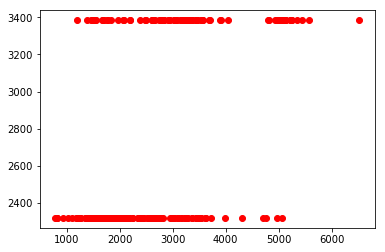

In [69]:
import matplotlib.pyplot as plt

plt.plot(df_sub['Json Yield'],y_pred,'ro')
plt.show()

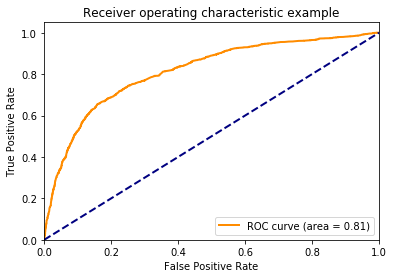

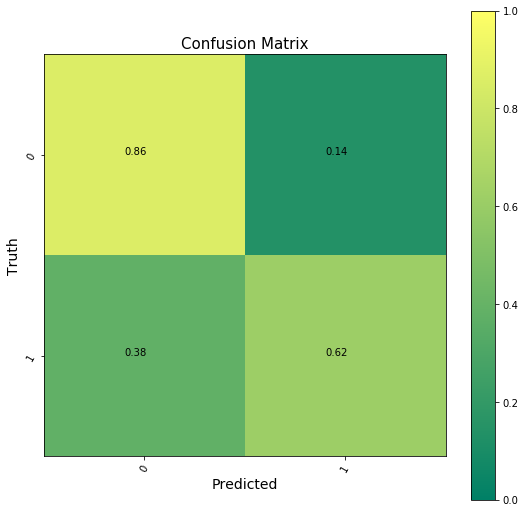

,serial,split,true_y,pred_y
0,567403,Validation,0,0.792220
1,573854,Validation,0,0.119861
2,577824,Validation,0,0.485571
3,593504,Validation,0,0.181170
4,598961,Validation,1,0.336047
5,609041,Validation,1,0.853749
6,609101,Validation,0,0.222492
7,611233,Validation,0,0.125600
8,612293,Validation,0,0.116665
9,617451,Validation,0,0.073494


In [32]:
# Model testing
val_lstm(sample_df, model_lstm.model, full_array_x, sample_df['y'], batch_size = 50, cutoff = 0.40,result_csv_save_name='lstm_result.csv')